In [ ]:
pip install fastai --upgrade

     |████████████████████████████████| 194kB 11.4MB/s 
     |████████████████████████████████| 61kB 4.4MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.vision.all import *
import os
import PIL
import numpy as np
import pandas as pd

In [ ]:
import zipfile
from zipfile import ZipFile
filename = 'archive.zip'
with ZipFile(filename,'r') as zip:
  zip.extractall()

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = data.to('cuda')
    model.to('cuda')

with torch.no_grad():
  output = model[data]
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

TypeError: ignored

In [ ]:
PATH="Alzheimer_s Dataset/"
sz=224
bs=58

In [ ]:
## get_image_files helps us get all the files inside a subfolder
fnames = get_image_files(PATH)
## creating an empty DataBlock object
dblock = DataBlock()

## converting the DataBlocks to DataSets
dsets = dblock.datasets(fnames)
## let look at one of the label names
parent_label(fnames[0])

'VeryMildDemented'

In [ ]:
lbl_dict = dict(
    MildDemented='mildDem',
    ModerateDemented='moderateDem',
    NonDemented='nonDem',
    VeryMildDemented='verymildDem'
)

In [ ]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [ ]:
dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(PATH)
dsets.train[0]

(Path('Alzheimer_s Dataset/train/VeryMildDemented/verymildDem1158.jpg'),
 'verymildDem')

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(PATH)
dsets.train[0]

(PILImage mode=RGB size=176x208, TensorCategory(2))

In [ ]:
dsets.vocab

['mildDem', 'moderateDem', 'nonDem', 'verymildDem']

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = GrandparentSplitter())

dsets = dblock.datasets(PATH)
dsets.train[0]

(PILImage mode=RGB size=176x208, TensorCategory(3))

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = GrandparentSplitter(),
                   item_tfms = RandomResizedCrop(128, min_scale=0.35), 
                   batch_tfms=Normalize.from_stats(*imagenet_stats))

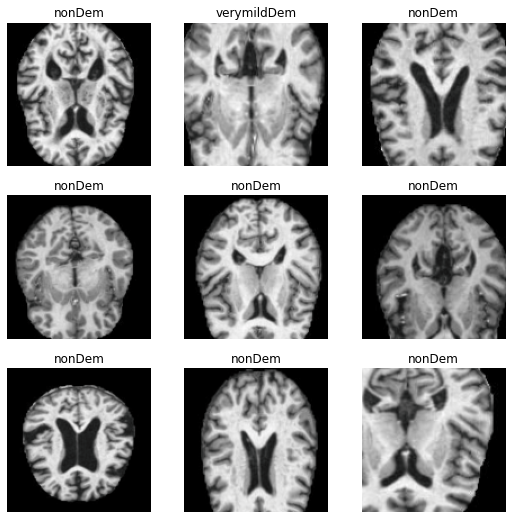

In [ ]:
dls = dblock.dataloaders(PATH)
dls.show_batch()

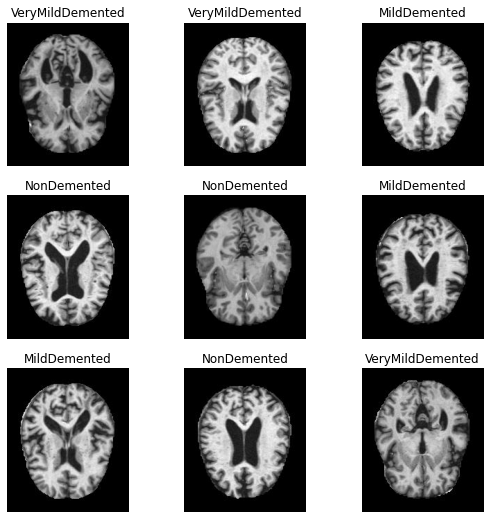

In [ ]:
data = ImageDataLoaders.from_folder(PATH, valid_pct=0.2,size=sz,bs=bs)
data.show_batch()

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=True):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1+cu101
Torchvision Version:  0.8.2+cu101


In [ ]:
pip install torch

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.779074,1.105559,0.596094,16:01


epoch,train_loss,valid_loss,accuracy,time
0,1.189549,0.822584,0.660937,19:52
1,0.976231,0.731480,0.689844,19:46
2,0.803297,0.635570,0.722656,19:50
3,0.640491,0.582365,0.742969,19:43
4,0.538224,0.561735,0.748438,19:41
5,0.485969,0.567961,0.743750,19:51


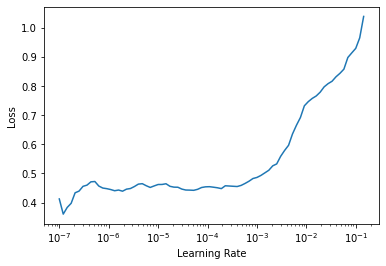

In [ ]:
arch  = torchvision.models.googlenet
learn = cnn_learner(data,arch, cut=-1, metrics=accuracy)
learn.fine_tune(6)
learn.lr_find();

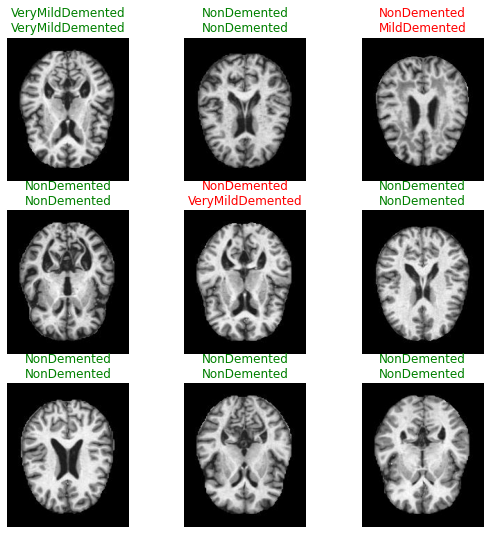

In [ ]:
learn.show_results()

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=9.12010818865383e-07)

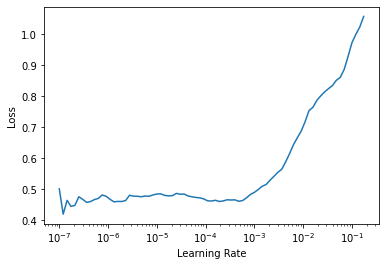

In [ ]:
learn.lr_find()

In [ ]:
interp = Interpretation.from_learner(learn)

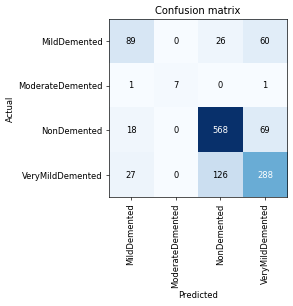

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [ ]:
inter = ClassificationInterpretation.from_learner(learn)
inter

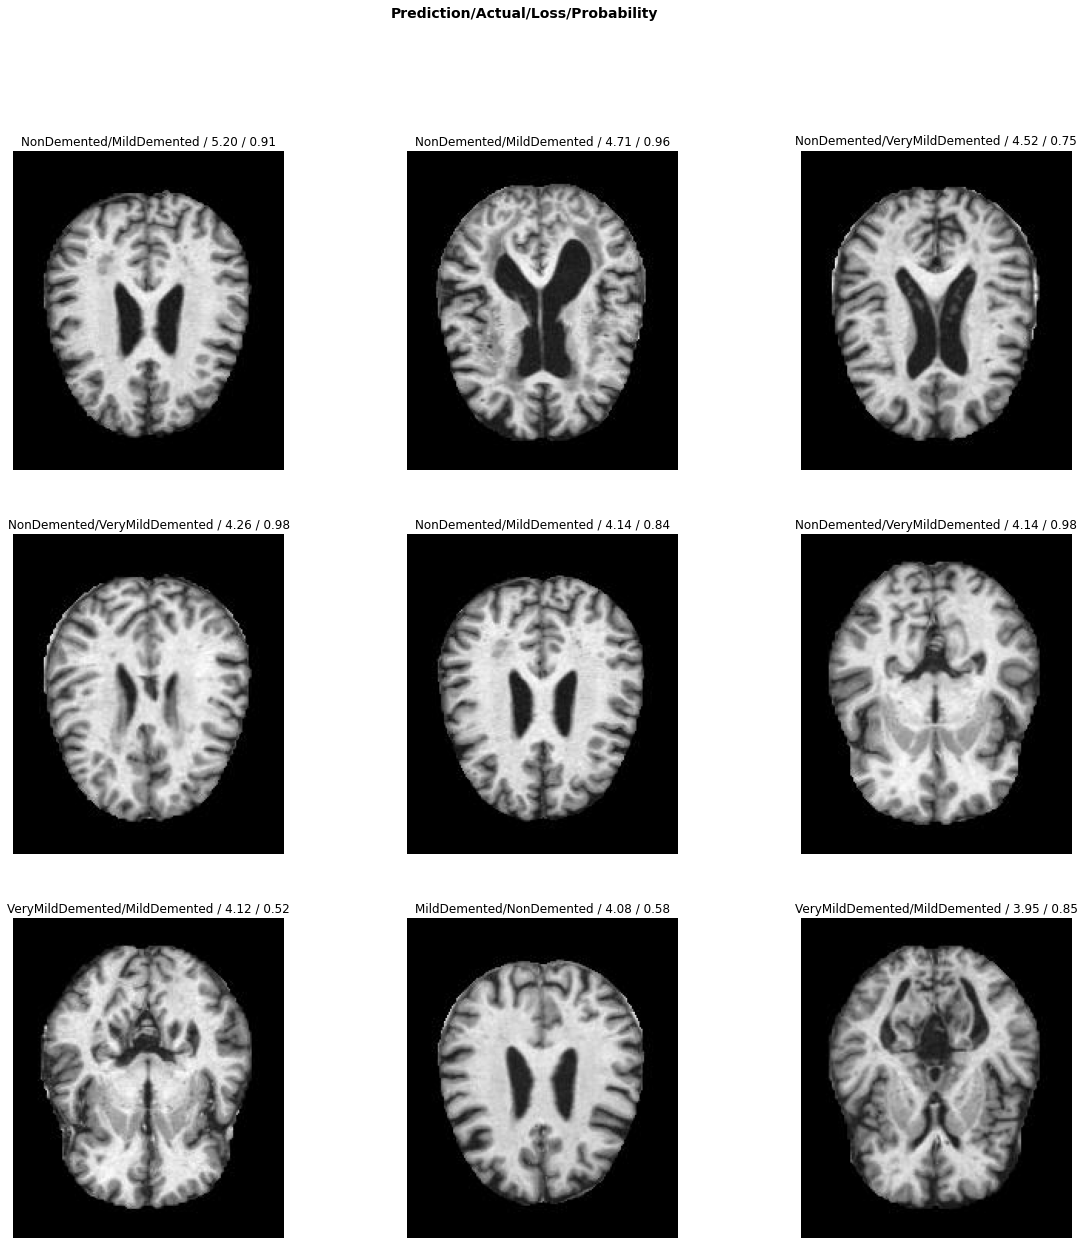

In [ ]:
interp.plot_top_losses(9, figsize=(20,20))
#predicted/actual/loss/probability

In [ ]:
learn.model_dir = "/kaggle/working"
learn.save("alzheimers")

Path('/kaggle/working/alzheimers.pth')

In [ ]:
learn.export(os.path.abspath('./export.pkl'))

Text(0.5, 1.0, 'Prediction : VeryMildDemented\nAccuracy : 80.92 %')

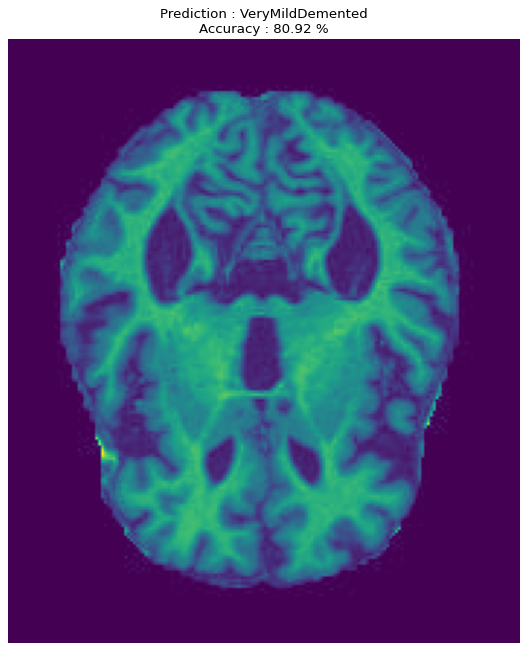

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
path = 'verymildDem (65).jpg'
pred = learn.predict(path)
test_img = Image.open(path)
plt.imshow(test_img)
plt.axis("off")
accuracy_rate = np.round(max(pred[2]).item()*100.0,2)
plt.title("Prediction : {}\nAccuracy : {} %".format(pred[0],accuracy_rate))

Text(0.5, 1.0, 'Prediction : NonDemented\nAccuracy : 99.18 %')

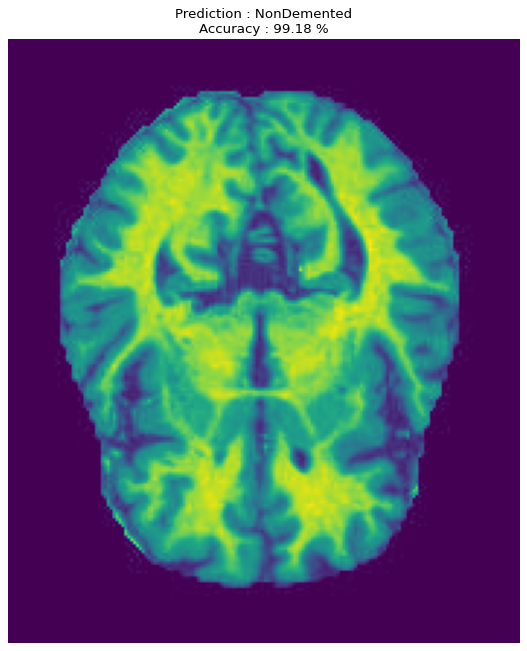

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
path = 'nonDem (7).jpg'
pred = learn.predict(path)
test_img = Image.open(path)
plt.imshow(test_img)
plt.axis("off")
accuracy_rate = np.round(max(pred[2]).item()*100.0,2)
plt.title("Prediction : {}\nAccuracy : {} %".format(pred[0],accuracy_rate))

Text(0.5, 1.0, 'Prediction : ModerateDemented\nAccuracy : 74.41 %')

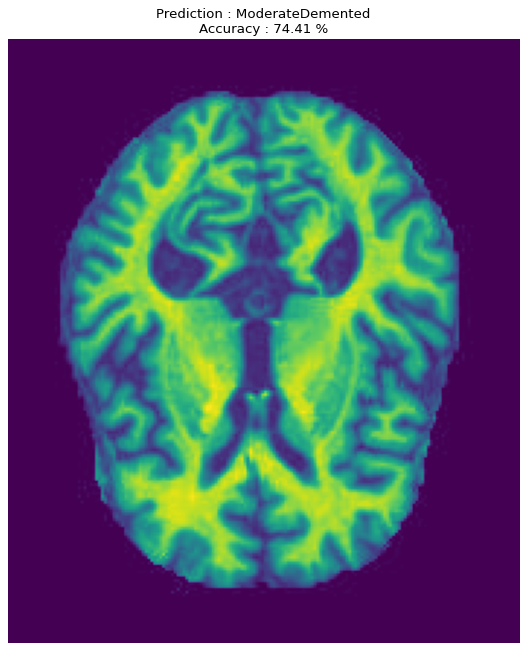

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
path = 'moderateDem (2).jpg'
pred = learn.predict(path)
test_img = Image.open(path)
plt.imshow(test_img)
plt.axis("off")
accuracy_rate = np.round(max(pred[2]).item()*100.0,2)
plt.title("Prediction : {}\nAccuracy : {} %".format(pred[0],accuracy_rate))

Text(0.5, 1.0, 'Prediction : VeryMildDemented\nAccuracy : 88.34 %')

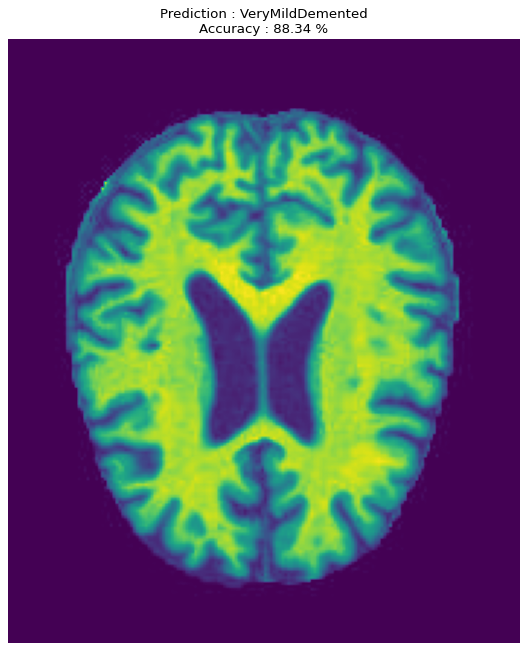

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
path = 'mildDem (2).jpg'
pred = learn.predict(path)
test_img = Image.open(path)
plt.imshow(test_img)
plt.axis("off")
accuracy_rate = np.round(max(pred[2]).item()*100.0,2)
plt.title("Prediction : {}\nAccuracy : {} %".format(pred[0],accuracy_rate))